# Text-to-3D Generation Practice
Text-to-3D 생성 모델 실습에 오신것을 환영합니다!

본 실습 세션에서는, 3DFuse(ArXiv 2023)에서 제안된 모델을 구현하여, text-to-3D 모델 생성을 실습해 볼 수 있습니다.

#3DFuse Pipeline: Text - to - image - to - 3D

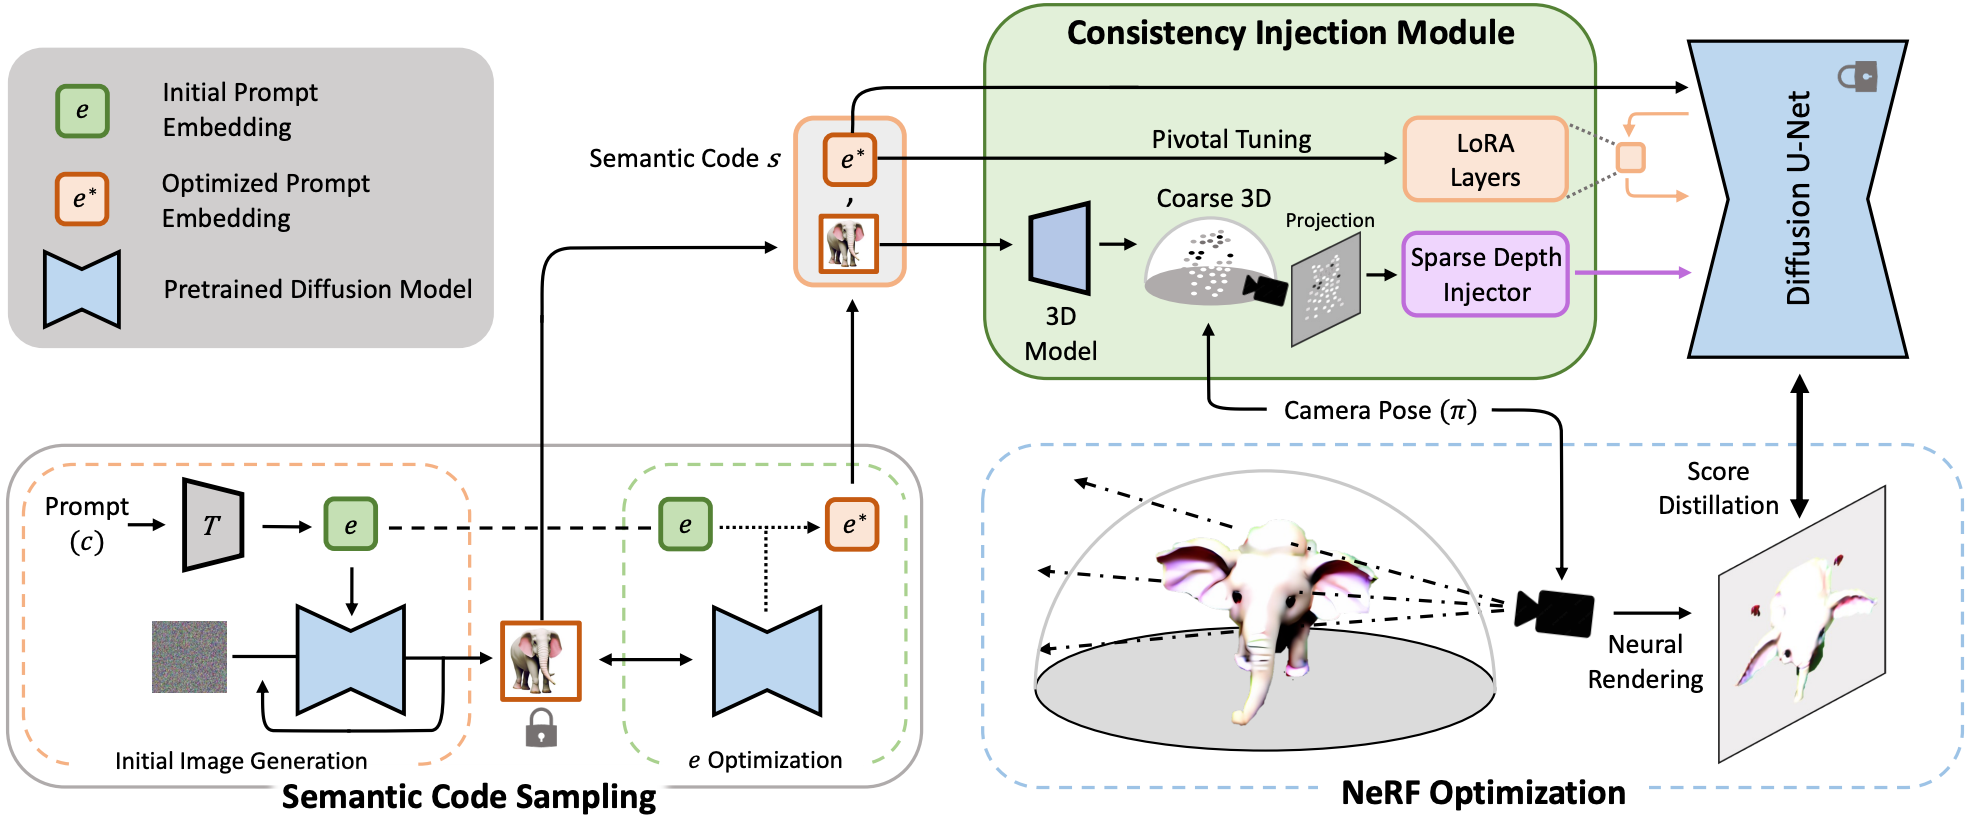

##Step 1. Setup

3DFuse에 필요한 Diffusion Model과 NeRF 학습을 위한 library 설치 및 setup을 진행합니다.

In [ ]:
# Python libraries requirement file download

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ctGO_QQFPSAIAIwi7ofdBfDLehjh3MG-' -O 'requirements.txt'

In [ ]:
# Downloading & setting up required auxiliary files

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AGerRrUUWu9M8V8OzryN_NlMmQ6m0RM0' -O fuse.zip
!unzip fuse.zip

In [ ]:
# Installing required libraries

!pip install -r requirements.txt

In [ ]:
# Installing Pytorch3D

!pip install git+https://github.com/facebookresearch/pytorch3d@c8af1c45ca9f4fdd4e59b49172ca74983ff3147a#egg=pytorch3d

In [ ]:
!mkdir weights
!cd weights
!wget https://huggingface.co/jyseo/3DFuse_weights/resolve/main/models/3DFuse_sparse_depth_injector.ckpt

In [ ]:
import os
import numpy as np
import torch
import imageio
import gradio as gr
import importlib

from einops import rearrange
from imageio import imwrite
from pydantic import validator
from omegaconf import OmegaConf
from PIL import Image

from my_config import BaseConf

In [ ]:
from adapt_sd import create_model, load_state_dict, load_embedding, merge

def load_3DFuse(control,dir,alpha):
    ######################LOADCONTROL###########################
    model = create_model(control['control_yaml']).cpu()
    model.load_state_dict(load_state_dict(control['control_weight'], location='cuda'))
    state_dict, l = merge("runwayml/stable-diffusion-v1-5",dir,alpha)

    #######################OVERRIDE#############################
    model.load_state_dict(state_dict,strict=False)

    #######################ADDEMBBEDDING########################
    load_embedding(model,l)
    ###############################################################
    return model

In [ ]:
from adapt import ScoreAdapter
from torch import autocast
from contextlib import nullcontext
from math import sqrt

def _sqrt(x):
    if isinstance(x, float):
        return sqrt(x)
    else:
        assert isinstance(x, torch.Tensor)
        return torch.sqrt(x)

class StableDiffusion(ScoreAdapter):
    def __init__(self, variant, v2_highres, prompt, scale, precision, dir, alpha=1.0):

        model=load_3DFuse(self.checkpoint_root(),dir,alpha)
        self.model = model.cuda()

        H , W = (512, 512)

        ae_resolution_f = 8

        self._device = self.model._device

        self.prompt = prompt
        self.scale = scale
        self.precision = precision
        self.precision_scope = autocast if self.precision == "autocast" else nullcontext
        self._data_shape = (4, H // ae_resolution_f, W // ae_resolution_f)

        self.cond_func = self.model.get_learned_conditioning
        self.M = 1000
        noise_schedule = "linear"
        self.noise_schedule = noise_schedule
        self.us = self.linear_us(self.M)

    def data_shape(self):
        return self._data_shape

    @property
    def σ_max(self):
        return self.us[0]

    @property
    def σ_min(self):
        return self.us[-1]

    @torch.no_grad()
    def denoise(self, xs, σ,control, **model_kwargs):
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                N = xs.shape[0]
                c = model_kwargs.pop('c')
                uc = model_kwargs.pop('uc')
                conditional_conditioning = {"c_concat": [control], "c_crossattn": [c]}
                unconditional_conditioning = {"c_concat": [control], "c_crossattn": [uc]}

                cond_t, σ = self.time_cond_vec(N, σ)
                unscaled_xs = xs
                xs = xs / _sqrt(1 + σ**2)
                if uc is None or self.scale == 1.:
                    output = self.model.apply_model(xs, cond_t, c)
                else:
                    x_in = torch.cat([xs] * 2)
                    t_in = torch.cat([cond_t] * 2)
                    c_in = dict()
                    for k in conditional_conditioning:
                        if isinstance(conditional_conditioning[k], list):
                            c_in[k] = [torch.cat([
                                unconditional_conditioning[k][i],
                                conditional_conditioning[k][i]]) for i in range(len(conditional_conditioning[k]))]
                        else:
                            c_in[k] = torch.cat([
                                    unconditional_conditioning[k],
                                    conditional_conditioning[k]])

                    e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
                    output = e_t_uncond + self.scale * (e_t - e_t_uncond)

                if self.model.parameterization == "v":
                    output = self.model.predict_eps_from_z_and_v(xs, cond_t, output)
                else:

                    output = output

                Ds = unscaled_xs - σ * output
                return Ds

    def cond_info(self, batch_size):
        prompts = batch_size * [self.prompt]
        return self.prompts_emb(prompts)

    @torch.no_grad()
    def prompts_emb(self, prompts):
        assert isinstance(prompts, list)
        batch_size = len(prompts)
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                cond = {}
                c = self.cond_func(prompts)
                cond['c'] = c
                uc = None
                if self.scale != 1.0:
                    uc = self.cond_func(batch_size * [""])
                cond['uc'] = uc
                return cond

    def unet_is_cond(self):
        return True

    def use_cls_guidance(self):
        return False

    def snap_t_to_nearest_tick(self, t):
        j = np.abs(t - self.us).argmin()
        return self.us[j], j

    def time_cond_vec(self, N, σ):
        if isinstance(σ, float):
            σ, j = self.snap_t_to_nearest_tick(σ)  # σ might change due to snapping
            cond_t = (self.M - 1) - j
            cond_t = torch.tensor([cond_t] * N, device=self.device)
            return cond_t, σ
        else:
            assert isinstance(σ, torch.Tensor)
            σ = σ.reshape(-1).cpu().numpy()
            σs = []
            js = []
            for elem in σ:
                _σ, _j = self.snap_t_to_nearest_tick(elem)
                σs.append(_σ)
                js.append((self.M - 1) - _j)

            cond_t = torch.tensor(js, device=self.device)
            σs = torch.tensor(σs, device=self.device, dtype=torch.float32).reshape(-1, 1, 1, 1)
            return cond_t, σs

    @staticmethod
    def linear_us(M=1000):
        assert M == 1000
        β_start = 0.00085
        β_end = 0.0120
        βs = np.linspace(β_start**0.5, β_end**0.5, M, dtype=np.float64)**2
        αs = np.cumprod(1 - βs)
        us = np.sqrt((1 - αs) / αs)
        us = us[::-1]
        return us

    @torch.no_grad()
    def encode(self, xs):
        model = self.model
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                zs = model.get_first_stage_encoding(
                    model.encode_first_stage(xs)
                )
        return zs

    @torch.no_grad()
    def decode(self, xs):
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                xs = self.model.decode_first_stage(xs)
                return xs


In [ ]:
class SD(BaseConf):
    """Stable Diffusion"""
    variant:        str = "v1"
    v2_highres:     bool = False
    prompt:         str = "a photograph of an astronaut riding a horse"
    scale:          float = 3.0  # classifier free guidance scale
    precision:      str = 'autocast'
    dir:            str = './'
    alpha:          float = 0.0 # merge scale

    def make(self):
        args = self.dict()
        model = StableDiffusion(**args)
        return model

In [ ]:
from my.config import BaseConf, SingleOrList, dispatch
from voxnerf.vox import VOXRF_REGISTRY

class VoxConfig(BaseConf):
    model_type:                 str = "VoxRF"
    bbox_len:                   float = 1.5
    grid_size:                  SingleOrList(int) = [128, 128, 128]
    step_ratio:                 float = 0.5
    density_shift:              float = -10.
    ray_march_weight_thres:     float = 0.0001
    c:                          int = 3
    blend_bg_texture:           bool = False
    bg_texture_hw:              int = 64

    @validator("grid_size")
    def check_gsize(cls, grid_size):
        if isinstance(grid_size, int):
            return [grid_size, ] * 3
        else:
            assert len(grid_size) == 3
            return grid_size

    def make(self):
        params = self.dict()
        m_type = params.pop("model_type")
        model_fn = VOXRF_REGISTRY.get(m_type)

        radius = params.pop('bbox_len')
        aabb = radius * np.array([
            [-1, -1, -1],
            [1, 1, 1]
        ])
        model = model_fn(aabb=aabb, **params)
        return model


In [ ]:
import numpy as np
from numpy import cross, tan
from numpy.linalg import norm, inv
from numpy import sin, cos
from math import pi as π

def normalize(v):
    return v / norm(v)


def camera_pose(eye, front, up):
    z = normalize(-1 * front)
    x = normalize(cross(up, z))
    y = normalize(cross(z, x))

    # convert to col vector
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    z = z.reshape(-1, 1)
    eye = eye.reshape(-1, 1)

    pose = np.block([
        [x, y, z, eye],
        [0, 0, 0, 1]
    ])
    return pose

def get_K(H, W, FoV_x):
    FoV_x = FoV_x / 180 * π  # to rad
    f = 1 / np.tan(FoV_x / 2) * (W / 2)

    K = np.array([
        [f, 0, -(W/2 - 0.5)],
        [0, -f, -(H/2 - 0.5)],
        [0, 0, -1]
    ])


    return K

SIDEVIEW_PROMPTS = [
    "front view of", "side view of", "backside view of", "side view of"
]

TOPVIEW_PROMPT = "overhead view of"


def train_eye_with_prompts(r, n):
    hs = np.random.rand(n) * 360
    vs = np.random.rand(n) * np.deg2rad(100)
    vs = np.clip(vs, 1e-2, π-1e-2)

    prompts = []
    v_thresh = np.deg2rad(30)
    for i in range(n):
        _p = ""
        if vs[i] < v_thresh:
            _p = TOPVIEW_PROMPT
        else:
            _a = hs[i]
            _a = (_a + 45) % 360
            _quad = int(_a // 90)
            _p = SIDEVIEW_PROMPTS[_quad]
        prompts.append(_p)

    θ = np.deg2rad(hs)
    # φ = v
    φ = np.arccos(1 - 2 * (vs / π))

    horz = hs
    elev = np.rad2deg(π / 2 - φ)

    eyes = np.zeros((n, 3))

    eyes[:, 0] = r * sin(φ) * cos(π-θ)  # x
    eyes[:, 2] = r * sin(φ) * sin(π-θ)  # z
    eyes[:, 1] = r * cos(φ)  # y

    return eyes, prompts, horz, elev


def spiral_poses(
    radius, height,
    num_steps=20, num_rounds=1,
    center=np.array([0, 0, 0]), up=np.array([0, 1, 0]),
):
    eyes = []
    for i in range(num_steps):
        ratio = (i + 1) / num_steps
        Δz = height * (1 - ratio)

        θ = ratio * (360 * num_rounds)
        θ = θ / 180 * π
        # _r = max(radius * ratio, 0.5)
        _r = max(radius * sin(ratio * π / 2), 0.5)
        Δx, Δy = _r * np.array([np.cos(θ), np.sin(θ)])
        eyes.append(center + [Δx, Δz, Δy])

    poses = [
        camera_pose(e, center - e, up) for e in eyes
    ]
    return poses

def circular_poses(
    radius, height,
    num_steps=36, num_rounds=1,
    center=np.array([0, 0, 0]), up=np.array([0, 1, 0]),
):
    eyes = []
    horz = []
    for i in range(num_steps):
        ratio = (i + 1) / num_steps
        Δz = radius * (np.cos(np.deg2rad(60)))

        θ = ratio * (360 * num_rounds)
        θ = θ / 180 * π
        # _r = max(radius * ratio, 0.5)
        _r = max(radius * sin(ratio * π / 2), 0.5)
        Δx, Δy = radius * np.array([np.sin(np.deg2rad(60))*np.cos(θ), np.sin(np.deg2rad(60))*np.sin(θ)])
        eyes.append(center + [Δx, Δz, Δy])
        horz.append(np.rad2deg(θ))
    poses = [
        camera_pose(e, center - e, up) for e in eyes
    ]
    horz=np.array(horz)
    return poses

class Poser():
    def __init__(self, H, W, FoV, R):
        self.H, self.W = H, W
        self.R = R
        self.K = get_K(H, W, FoV)
        self.FoV = FoV

    def sample_train(self, n, device):
        eyes, prompts, horz, elev = train_eye_with_prompts(r=self.R, n=n)
        up = np.array([0, 1, 0])

        poses = [
            camera_pose(e, -e, up) for e in eyes
        ]
        poses = np.stack(poses, 0)

        FoV = np.random.rand(n) * 30 + 40

        random_Ks = [
            get_K(self.H, self.W, FoV[i])
            for i in range(len(poses))

        ]

        angles_list = []

        for horizontal, elevation, fov in zip(horz, elev, FoV):
            angles_list.append([horizontal, elevation, fov])

        return random_Ks, poses, prompts, angles_list

    def sample_test(self, n):
        poses = circular_poses(self.R, self.R, n, num_rounds=3)
        poses = np.stack(poses, axis=0)
        return self.K, poses


class PoseConfig(BaseConf):
    rend_hw: int = 64
    FoV: float = 60.0
    R: float = 1.5

    def make(self):
        cfgs = self.dict()
        hw = cfgs.pop("rend_hw")
        cfgs["H"] = hw
        cfgs["W"] = hw
        return Poser(**cfgs)

In [ ]:
def load_3DFuse(control,dir,alpha):
    ######################LOADCONTROL###########################
    model = create_model(control['control_yaml']).cpu()
    model.load_state_dict(load_state_dict(control['control_weight'], location='cuda'))
    state_dict, l = merge("runwayml/stable-diffusion-v1-5",dir,alpha)

    #######################OVERRIDE#############################
    model.load_state_dict(state_dict,strict=False)

    #######################ADDEMBBEDDING########################
    load_embedding(model,l)
    ###############################################################
    return model

class StableDiffusion(ScoreAdapter):
    def __init__(self, variant, v2_highres, prompt, scale, precision, dir, alpha=1.0):

        model=load_3DFuse(self.checkpoint_root(),dir,alpha)
        self.model = model.cuda()

        H , W = (512, 512)

        ae_resolution_f = 8

        self._device = self.model._device

        self.prompt = prompt
        self.scale = scale
        self.precision = precision
        self.precision_scope = autocast if self.precision == "autocast" else nullcontext
        self._data_shape = (4, H // ae_resolution_f, W // ae_resolution_f)

        self.cond_func = self.model.get_learned_conditioning
        self.M = 1000
        noise_schedule = "linear"
        self.noise_schedule = noise_schedule
        self.us = self.linear_us(self.M)

    def data_shape(self):
        return self._data_shape

    @property
    def σ_max(self):
        return self.us[0]

    @property
    def σ_min(self):
        return self.us[-1]

    @torch.no_grad()
    def denoise(self, xs, σ,control, **model_kwargs):
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                N = xs.shape[0]
                c = model_kwargs.pop('c')
                uc = model_kwargs.pop('uc')
                conditional_conditioning = {"c_concat": [control], "c_crossattn": [c]}
                unconditional_conditioning = {"c_concat": [control], "c_crossattn": [uc]}

                cond_t, σ = self.time_cond_vec(N, σ)
                unscaled_xs = xs
                xs = xs / _sqrt(1 + σ**2)
                if uc is None or self.scale == 1.:
                    output = self.model.apply_model(xs, cond_t, c)
                else:
                    x_in = torch.cat([xs] * 2)
                    t_in = torch.cat([cond_t] * 2)
                    c_in = dict()
                    for k in conditional_conditioning:
                        if isinstance(conditional_conditioning[k], list):
                            c_in[k] = [torch.cat([
                                unconditional_conditioning[k][i],
                                conditional_conditioning[k][i]]) for i in range(len(conditional_conditioning[k]))]
                        else:
                            c_in[k] = torch.cat([
                                    unconditional_conditioning[k],
                                    conditional_conditioning[k]])

                    e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
                    output = e_t_uncond + self.scale * (e_t - e_t_uncond)

                if self.model.parameterization == "v":
                    output = self.model.predict_eps_from_z_and_v(xs, cond_t, output)
                else:

                    output = output

                Ds = unscaled_xs - σ * output
                return Ds

    def cond_info(self, batch_size):
        prompts = batch_size * [self.prompt]
        return self.prompts_emb(prompts)

    @torch.no_grad()
    def prompts_emb(self, prompts):
        assert isinstance(prompts, list)
        batch_size = len(prompts)
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                cond = {}
                c = self.cond_func(prompts)
                cond['c'] = c
                uc = None
                if self.scale != 1.0:
                    uc = self.cond_func(batch_size * [""])
                cond['uc'] = uc
                return cond

    def unet_is_cond(self):
        return True

    def use_cls_guidance(self):
        return False

    def snap_t_to_nearest_tick(self, t):
        j = np.abs(t - self.us).argmin()
        return self.us[j], j

    def time_cond_vec(self, N, σ):
        if isinstance(σ, float):
            σ, j = self.snap_t_to_nearest_tick(σ)  # σ might change due to snapping
            cond_t = (self.M - 1) - j
            cond_t = torch.tensor([cond_t] * N, device=self.device)
            return cond_t, σ
        else:
            assert isinstance(σ, torch.Tensor)
            σ = σ.reshape(-1).cpu().numpy()
            σs = []
            js = []
            for elem in σ:
                _σ, _j = self.snap_t_to_nearest_tick(elem)
                σs.append(_σ)
                js.append((self.M - 1) - _j)

            cond_t = torch.tensor(js, device=self.device)
            σs = torch.tensor(σs, device=self.device, dtype=torch.float32).reshape(-1, 1, 1, 1)
            return cond_t, σs

    @staticmethod
    def linear_us(M=1000):
        assert M == 1000
        β_start = 0.00085
        β_end = 0.0120
        βs = np.linspace(β_start**0.5, β_end**0.5, M, dtype=np.float64)**2
        αs = np.cumprod(1 - βs)
        us = np.sqrt((1 - αs) / αs)
        us = us[::-1]
        return us

    @torch.no_grad()
    def encode(self, xs):
        model = self.model
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                zs = model.get_first_stage_encoding(
                    model.encode_first_stage(xs)
                )
        return zs

    @torch.no_grad()
    def decode(self, xs):
        with self.precision_scope("cuda"):
            with self.model.ema_scope():
                xs = self.model.decode_first_stage(xs)
                return xs




class SD(BaseConf):
    """Stable Diffusion"""
    variant:        str = "v1"
    v2_highres:     bool = False
    prompt:         str = "a photograph of an astronaut riding a horse"
    scale:          float = 3.0  # classifier free guidance scale
    precision:      str = 'autocast'
    dir:            str = './'
    alpha:          float = 0.0 # merge scale

    def make(self):
        args = self.dict()
        model = StableDiffusion(**args)
        return model

In [ ]:
from voxnerf.utils import every
from voxnerf.render import (
    as_torch_tsrs, rays_from_img, ray_box_intersect, render_ray_bundle
)
from voxnerf.vis import stitch_vis, bad_vis as nerf_vis


def torch_samps_to_imgs(imgs, uncenter=True):
    if uncenter:
        imgs = (imgs + 1) / 2  # [-1, 1] -> [0, 1]
    imgs = (imgs * 255).clamp(0, 255)
    imgs = imgs.to(torch.uint8)
    imgs = imgs.permute(0, 2, 3, 1)
    imgs = imgs.cpu().numpy()
    return imgs


def vis_routine(metric, y, depth,prompt,depth_map):
    pane = nerf_vis(y, depth, final_H=256)
    im = torch_samps_to_imgs(y)[0]

    depth = depth.cpu().numpy()
    metric.put_artifact("view", ".png","",lambda fn: imwrite(fn, pane))
    metric.put_artifact("img", ".png",prompt, lambda fn: imwrite(fn, im))
    if depth_map != None:
        metric.put_artifact("PC_depth", ".png",prompt, lambda fn: imwrite(fn, depth_map.cpu().squeeze()))
    metric.put_artifact("depth", ".npy","",lambda fn: np.save(fn, depth))


def scene_box_filter_(ro, rd, aabb):
    _, t_min, t_max = ray_box_intersect(ro, rd, aabb)
    # do not render what's behind the ray origin
    t_min, t_max = np.maximum(t_min, 0), np.maximum(t_max, 0)
    return ro, rd, t_min, t_max


def render_one_view(vox, aabb, H, W, K, pose, return_w=False):
    N = H * W
    ro, rd = rays_from_img(H, W, K, pose)

    ro, rd, t_min, t_max = scene_box_filter_(ro, rd, aabb)

    assert len(ro) == N, "for now all pixels must be in"
    ro, rd, t_min, t_max = as_torch_tsrs(vox.device, ro, rd, t_min, t_max)
    rgbs, depth, weights = render_ray_bundle(vox, ro, rd, t_min, t_max)

    rgbs = rearrange(rgbs, "(h w) c -> 1 c h w", h=H, w=W)
    depth = rearrange(depth, "(h w) 1 -> h w", h=H, w=W)
    if return_w:
        return rgbs, depth, weights
    else:
        return rgbs, depth

def tsr_stats(tsr):
    return {
        "mean": tsr.mean().item(),
        "std": tsr.std().item(),
        "max": tsr.max().item(),
    }

In [ ]:
from my.utils.event import EventStorage, get_event_storage, read_stats
from my.utils.heartbeat import HeartBeat, get_heartbeat
from my.utils.debug import EarlyLoopBreak
from my.utils.tqdm import tqdm

@torch.no_grad()
def evaluate(score_model, vox, poser):
    H, W = poser.H, poser.W
    vox.eval()
    K, poses = poser.sample_test(100)

    fuse = EarlyLoopBreak(5)
    metric = get_event_storage()
    hbeat = get_heartbeat()

    aabb = vox.aabb.T.cpu().numpy()
    vox = vox.to(device_glb)

    num_imgs = len(poses)

    for i in (pbar := tqdm(range(num_imgs))):
        if fuse.on_break():
            break

        pose = poses[i]
        y, depth = render_one_view(vox, aabb, H, W, K, pose)
        y = score_model.decode(y)
        vis_routine(metric, y, depth,"",None)

        metric.step()
        hbeat.beat()

    metric.flush_history()

    metric.put_artifact(
        "video", ".mp4","",
        lambda fn: stitch_vis(fn, read_stats(metric.output_dir, "img")[1])
    )

    metric.step()

In [ ]:
from pytorch3d.renderer import PointsRasterizationSettings


def fuse_3d(
    poser, vox, model: ScoreAdapter,
    lr, n_steps, emptiness_scale, emptiness_weight, emptiness_step, emptiness_multiplier,
    depth_weight, var_red, exp_instance_dir, points, is_gradio, **kwargs
):
    del kwargs
    if is_gradio:
        yield gr.update(visible=True), "LoRA layers tuning has just finished. \nScore distillation has started.", gr.update(visible=True)

    assert model.samps_centered()
    _, target_H, target_W = model.data_shape()
    bs = 1
    aabb = vox.aabb.T.cpu().numpy()
    vox = vox.to(device_glb)
    opt = torch.optim.Adamax(vox.opt_params(), lr=lr)

    H, W = poser.H, poser.W
    Ks_, poses_, prompt_prefixes_, angles_list = poser.sample_train(n_steps,device_glb)

    ts = model.us[30:-10]

    fuse = EarlyLoopBreak(5)

    raster_settings = PointsRasterizationSettings(
                image_size= 800,
                radius = 0.02,
                points_per_pixel = 10
            )

    ts = model.us[30:-10]
    calibration_value=0.0



    with tqdm(total=n_steps) as pbar, \
        HeartBeat(pbar) as hbeat, \
            EventStorage(output_dir=os.path.join(exp_instance_dir,'3d')) as metric:

        for i in range(len(poses_)):
            if fuse.on_break():
                break

            depth_map = render_depth_from_cloud(points, angles_list[i], raster_settings, device_glb,calibration_value)

            y, depth, ws = render_one_view(vox, aabb, H, W, Ks_[i], poses_[i], return_w=True)

            p = f"{prompt_prefixes_[i]} {model.prompt}"
            score_conds = model.prompts_emb([p])

            score_conds['c']=score_conds['c'].repeat(bs,1,1)
            score_conds['uc']=score_conds['uc'].repeat(bs,1,1)

            opt.zero_grad()

            with torch.no_grad():
                chosen_σs = np.random.choice(ts, bs, replace=False)
                chosen_σs = chosen_σs.reshape(-1, 1, 1, 1)
                chosen_σs = torch.as_tensor(chosen_σs, device=model.device, dtype=torch.float32)


                noise = torch.randn(bs, *y.shape[1:], device=model.device)

                zs = y + chosen_σs * noise

                Ds = model.denoise(zs, chosen_σs,depth_map.unsqueeze(dim=0),**score_conds)

                if var_red:
                    grad = (Ds - y) / chosen_σs
                else:
                    grad = (Ds - zs) / chosen_σs

                grad = grad.mean(0, keepdim=True)

            y.backward(-grad, retain_graph=True)

            if depth_weight > 0:
                center_depth = depth[7:-7, 7:-7]
                border_depth_mean = (depth.sum() - center_depth.sum()) / (64*64-50*50)
                center_depth_mean = center_depth.mean()
                depth_diff = center_depth_mean - border_depth_mean
                depth_loss = - torch.log(depth_diff + 1e-12)
                depth_loss = depth_weight * depth_loss
                depth_loss.backward(retain_graph=True)

            emptiness_loss = torch.log(1 + emptiness_scale * ws).mean()
            emptiness_loss = emptiness_weight * emptiness_loss
            if emptiness_step * n_steps <= i:
                emptiness_loss *= emptiness_multiplier
            emptiness_loss.backward()

            opt.step()

            metric.put_scalars(**tsr_stats(y))

            if every(pbar, percent=2):
                with torch.no_grad():
                    y = model.decode(y)
                    vis_routine(metric, y, depth,p,depth_map[0])

                    if is_gradio :
                        yield torch_samps_to_imgs(y)[0], f"Progress: {pbar.n}/{pbar.total} \nAfter the generation is complete, the video results will be displayed below.", gr.update(value=None)


            metric.step()
            pbar.update()

            pbar.set_description(p)
            hbeat.beat()

        metric.put_artifact(
            "ckpt", ".pt","", lambda fn: torch.save(vox.state_dict(), fn)
        )

        with EventStorage("result"):
            evaluate(model, vox, poser)

        if is_gradio:
            yield gr.update(visible=True), f"Generation complete. Please check the video below. \nThe result files and logs are located at {exp_instance_dir}", gr.update(value=os.path.join(exp_instance_dir,'3d/result_10000/video/step_100_.mp4'))
        else :
            yield None

        metric.step()

        hbeat.done()

In [ ]:
from pydantic import validator
from my.utils.seed import seed_everything
from semantic_coding import semantic_coding, semantic_karlo, semantic_sd
from pc_project import point_e, render_depth_from_cloud

device_glb = torch.device("cuda")

class SJC_3DFuse(BaseConf):
    family:     str = "sd"
    sd:         SD = SD(
        variant="v1",
        prompt="a comfortable bed",
        scale=100.0,
        dir="./results",
        alpha=0.3
    )
    lr:         float = 0.05
    n_steps:    int = 10000
    vox:        VoxConfig = VoxConfig(
        model_type="V_SD", grid_size=100, density_shift=-1.0, c=3,
        blend_bg_texture=False , bg_texture_hw=4,
        bbox_len=1.0
    )
    pose:       PoseConfig = PoseConfig(rend_hw=64, FoV=60.0, R=1.5)

    emptiness_scale:    int = 10
    emptiness_weight:   int = 1e4
    emptiness_step:     float = 0.5
    emptiness_multiplier: float = 20.0

    depth_weight:       int = 0

    var_red:     bool = True
    exp_dir:     str = "./results"
    ti_step:     int = 10
    pt_step:     int = 10
    initial:    str = ""
    random_seed:     int = 0
    semantic_model:     str = "Karlo"
    bg_preprocess:     bool = True
    num_initial_image:     int = 4

    @validator("vox")
    def check_vox(cls, vox_cfg, values):
        family = values['family']
        if family == "sd":
            vox_cfg.c = 4
        return vox_cfg

    def run(self):
        cfgs = self.dict()
        seed = cfgs.pop('random_seed')
        seed_everything(seed)
        initial = cfgs.pop('initial')
        exp_instance_dir=os.path.join(cfgs.pop('exp_dir'),initial)

        initial_prompt=cfgs['sd']['prompt']
        semantic_model = cfgs.pop('semantic_model')

        # Initial image generation
        image_dir=os.path.join(exp_instance_dir,'initial_image')

        if semantic_model == "Karlo":
            semantic_karlo(initial_prompt,image_dir,cfgs['num_initial_image'],cfgs['bg_preprocess'], seed)
        elif semantic_model == "SD":
            semantic_sd(initial_prompt,image_dir,cfgs['num_initial_image'],cfgs['bg_preprocess'], seed)
        else:
            raise NotImplementedError

        # Optimization  and pivotal tuning for LoRA
        semantic_coding(exp_instance_dir,cfgs,self.sd,initial)


        # Load SD with Consistency Injection Module
        family = cfgs.pop("family")
        model = getattr(self, family).make()
        print(model.prompt)
        cfgs.pop("vox")
        vox = self.vox.make()

        cfgs.pop("pose")
        poser = self.pose.make()

        # Get coarse point cloud from off-the-shelf model
        points = point_e(device=device_glb,exp_dir=exp_instance_dir)

        # Score distillation
        next(fuse_3d(**cfgs, poser=poser,model=model,vox=vox,exp_instance_dir=exp_instance_dir, points=points, is_gradio=False))


In [ ]:
SJC_3DFuse().run()